<h1>ITNPDB2 Representing and Manipulating Data</h1>
<h3>University of Stirling<br>Dr. Saemundur Haraldsson</h3>

<h1>Web scraping and text processing</h1>
    
<h2>Web scraping</h2>
<h4>
    <ul>
        <li>Scrapy <a href="https://docs.scrapy.org/en/latest/">(documentation)</a></li>
        <li>BeautifulSoup <a href="https://www.crummy.com/software/BeautifulSoup/bs4/doc/">(documentation)</a></li>
    </ul>
</h4>

In [2]:
# First we'll import the packages we'll need
import logging
import scrapy
import scrapy.crawler as crawler
from bs4 import BeautifulSoup
from scrapy.crawler import CrawlerRunner
from scrapy.crawler import CrawlerProcess

# Scrapy - for data mining websites
- Web crawling
- Web scraping 
- Open source 
- Extendable
- Uses http <a href="http://doc.scrapy.org/en/latest/topics/request-response.html">__Requests__ and __Responses__</a>
 - Implement Python classes that represent http communications with relevant attributes

## Scrapy works best as a separate process
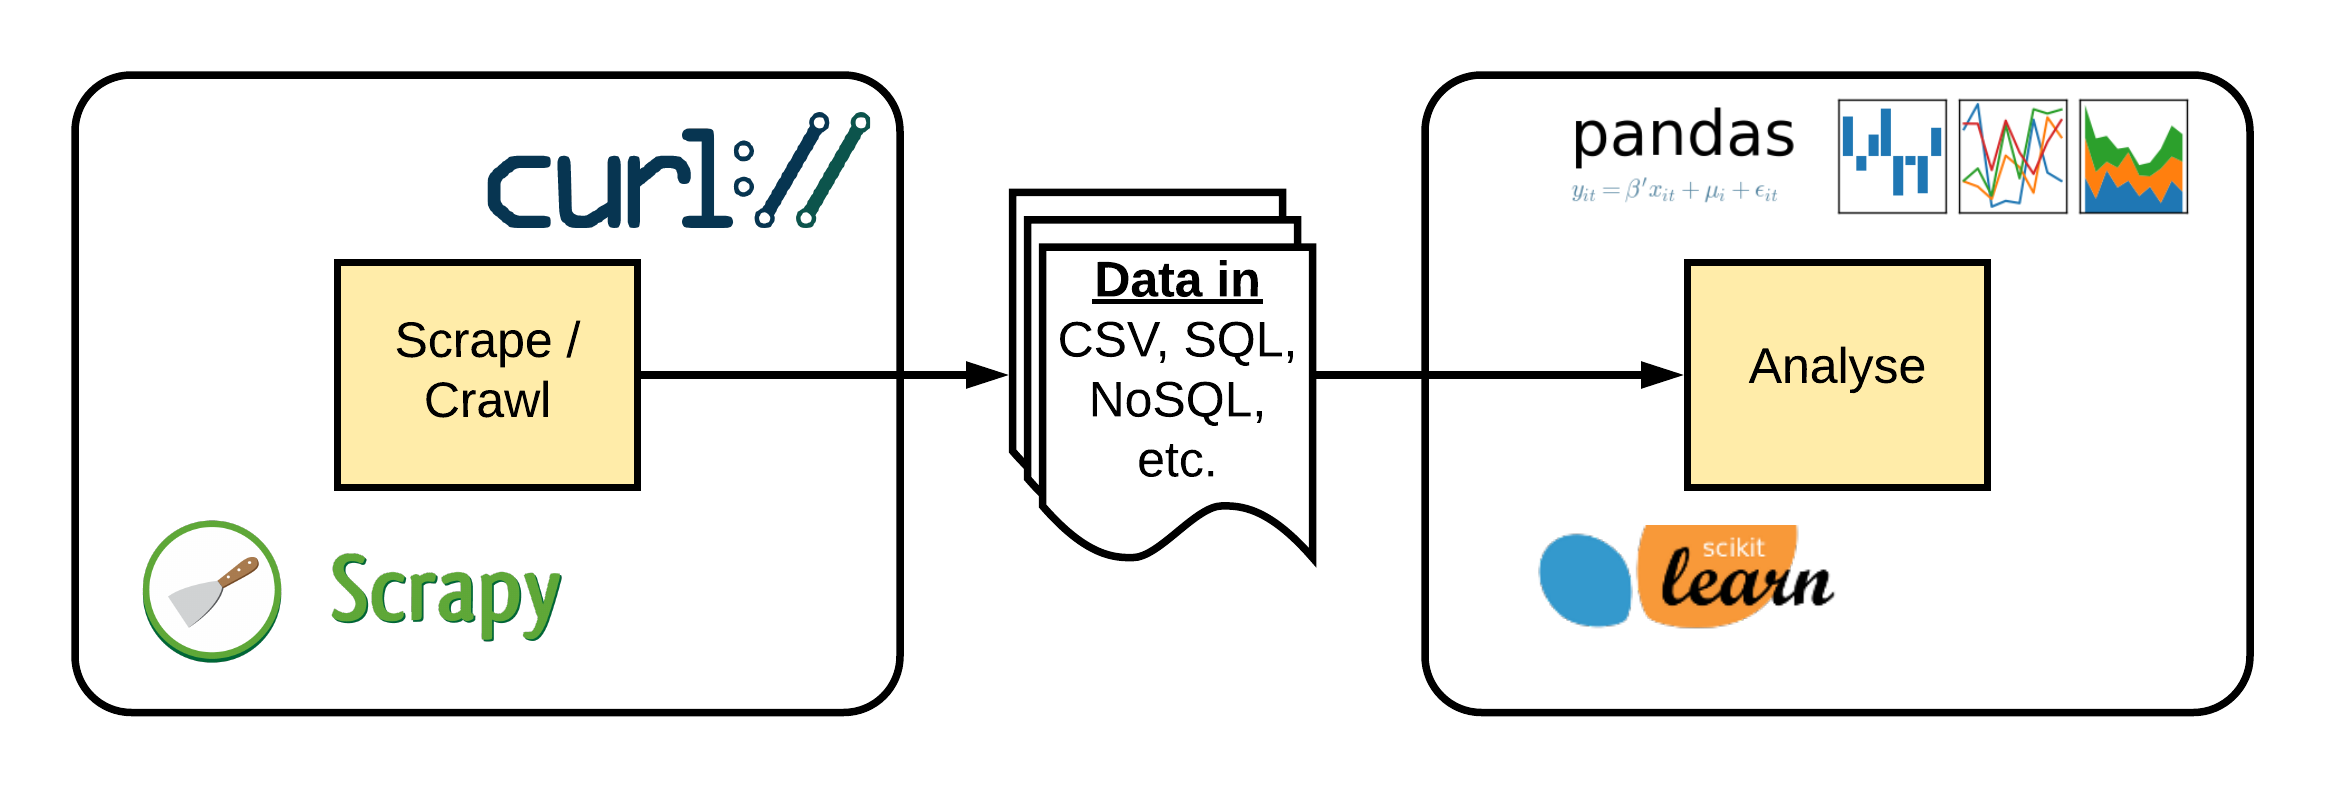

## First some house keeping
- Scrapy doesn't play well with notebooks so we need to write a wrapper that allows us to run crawlers/spiders more than once without having to restart the kernel everytime

### *Not necessary to understand exactly what this does just trust that it serves its purpose

In [3]:
# We have to import these to be able to run Scrapy more than once in the notebook
from multiprocessing import Process, Queue
from twisted.internet import reactor

def run_spider(spider):
    """A wrapper that uses threading to be able to run spiders more than once"""
    def f(q):
        try:
            runner = crawler.CrawlerRunner()
            deferred = runner.crawl(spider)
            deferred.addBoth(lambda _: reactor.stop())
            reactor.run()
            q.put(None)
        except Exception as e:
            q.put(e)
    q = Queue()
    p = Process(target=f, args=(q,))
    p.start()
    result = q.get()
    p.join()
    if result is not None:
        raise result

## Spiders
- User defined classes
- What Scrapy uses to crawl websites and scrape information
- Extends the generic class <strong>scrapy.Spider</strong>
- At bare minimum should define/include:
 - how information is parsed in a __parse__ method
 - the URL where the crawl should start in a __start_requests__ method
 - A name as an __attribute__

### Our first spider will scrape a single webpage from the CS&M Division site
- Using __response__

In [4]:
class CSStaff(scrapy.Spider):
    """A spider for extracting CS Stirling staff page."""
    name="CSStaff"
    def start_requests(self):
        urls = [
            'http://www.cs.stir.ac.uk/intro/whoiswho.html'
        ]
        for url in urls:
            yield scrapy.Request(url=url, callback=self.parse)
    def parse(self, response):
        print(response.body)

# And run the spider with our customised run_spider function
# it doesn't return anything so there's no value to store in a variable
run_spider(CSStaff)

b'<!--[if HTML5]><![endif]-->\n<!DOCTYPE html>\n<!--[if IE 8]>    <html class="no-js lt-ie9" lang="en"> <![endif]-->\n<!--[if gt IE 8]><!--> <html class="no-js" lang="en"> <!--<![endif]-->\n<head>\n<title>Staff List for Computing Science and Mathematics,\n       University of Stirling, SCOTLAND</title>\n<meta name="keywords" content="" />\n<meta name="description" content="" />\n<meta name="author" content="Graham Cochrane" />\n  <meta charset="utf-8" />\n  <meta http-equiv="X-UA-Compatible" content="IE=10" />\n  <meta name="viewport" content="width=device-width" />\n    <!-- Uni CSS -->\n<link href=\'//fonts.googleapis.com/css?family=Lato:300\' rel=\'stylesheet\' type=\'text/css\' />\n<link href=\'//fonts.googleapis.com/css?family=Shadows+Into+Light\' rel=\'stylesheet\' type=\'text/css\' />\n<link href=\'//fonts.googleapis.com/css?family=Open+Sans:400italic,700italic,400,700\' rel=\'stylesheet\' type=\'text/css\' />\n\n  <!-- link rel="stylesheet" type="text/css" href="//www.stir.ac.u

### Our first spider was debatably useful to us
### Say we want to scrape the names of our CS staff from our webpage
- We'll use CSS tags to identify what parts to scrape
 - CSS is a markup language used for applying styles to HTML documents
 - Have to look for that in the source of the webpage: http://www.cs.stir.ac.uk/intro/whoiswho.html <br> or with other available tools not introduced here
 - We can use CSS/HTML tags to identify elements: __div__, __td__, etc. 
 - https://www.w3.org/TR/2011/REC-css3-selectors-20110929/
 - __Let's see if we can find the combination of tags that will give us only elements containing names of staff members__

#### response.css() produces a list of CSS selector objects

In [5]:
class CSStaff_CSS(scrapy.Spider):
    """A spider for extracting names of CS Stirling staff."""
    name="CSStaff_CSS"
    def start_requests(self):
        urls = [
            'http://www.cs.stir.ac.uk/intro/whoiswho.html'
        ]
        for url in urls:
            yield scrapy.Request(url=url, callback=self.parse)
    def parse(self, response):
        # change the input string to tell Scrapy what elements from the html you want
        print(response.css('td > input').getall())

run_spider(CSStaff_CSS)

['<input name="user" class="deptbutton" value="Prof Richard Connor" type="submit">', '<input name="user" class="deptbutton" value="Grace McArthur" type="submit">', '<input name="user" class="deptbutton" value="Gemma Gardiner" type="submit">', '<input name="user" class="deptbutton" value="Prof Bruce Graham" type="submit">', '<input name="user" class="deptbutton" value="Prof Rachel Norman" type="submit">', '<input name="user" class="deptbutton" value="Prof Gabriela Ochoa" type="submit">', '<input name="user" class="deptbutton" value="Prof Carron Shankland" type="submit">', '<input name="user" class="deptbutton" value="Dr Jozsef Farkas" type="submit">', '<input name="user" class="deptbutton" value="Dr Jingpeng Li" type="submit">', '<input name="user" class="deptbutton" value="Dr Andrew Hoyle" type="submit">', '<input name="user" class="deptbutton" value="Dr Mario Kolberg" type="submit">', '<input name="user" class="deptbutton" value="Dr Kevin Swingler" type="submit">', '<input name="user"

## That got us the elements but we want the information from the elements
- A bit more powerful selection method is to use XPath syntax 
 - https://www.w3schools.com/xml/xpath_intro.asp
 - https://docs.scrapy.org/en/xpath-tutorial/topics/xpath-tutorial.html
 - Accesses the same tags as the CSS method (actually the CSS method uses XPath under the hood)
 - XPath is a language used to select nodes in an XML documents
 - Can be used to extract attribute values from the nodes


In [6]:
class CSStaff_XPATH(scrapy.Spider):
    """A spider for extracting names of CS Stirling staff."""
    name="CSStaff_XPATH"
    def start_requests(self):
        urls = [
            'http://www.cs.stir.ac.uk/intro/whoiswho.html'
        ]
        for url in urls:
            yield scrapy.Request(url=url, callback=self.parse)
    def parse(self, response):
        print(response.xpath("//input[contains(@class,'deptbutton')]/@value").getall())

run_spider(CSStaff_XPATH)

['Prof Richard Connor', 'Grace McArthur', 'Gemma Gardiner', 'Prof Bruce Graham', 'Prof Rachel Norman', 'Prof Gabriela Ochoa', 'Prof Carron Shankland', 'Dr Jozsef Farkas', 'Dr Jingpeng Li', 'Dr Andrew Hoyle', 'Dr Mario Kolberg', 'Dr Kevin Swingler', 'Dr Deepayan Bhowmik', 'Dr Andrea Bracciali', 'Dr Sandy Brownlee', 'Dr David Cairns', 'Dr Simona Hapca', 'Dr Saemundur Haraldsson', 'Dr Simon Jones', 'Dr Anya Kirpichnikova', 'Dr Wen-shin Lee', 'Dr Savi Maharaj', 'Dr Patrick Maier', 'Dr Paul McMenemy', 'Dr Keiller Nogueira', "Dr Anthony O'Hare", 'Kate Howie', 'Dr Penny Jackson', 'Donald Smith', 'Dr Jason Adair', 'Dr Adam Linson', 'Dr Ken Reid', 'Sam Nelson', 'Graham Cochrane', 'Chris Grigson', 'Penny Johnston', 'Stefano Sarti', 'Mohammad Alharbi', 'Teymoor Ali', 'Abdulrahman Alqarafi', 'Scott Bee', 'Lee Benson', 'Alexander Carmichael', 'Ipshita Roy Chowdhury', 'Vincenzo Crescimanna', 'Craig Docherty', 'Muyao Fan', 'Mila Goranova', 'Kevin Graham', 'Fidelis Henry Kamunde', 'Kaushal Kumar', 'Am

In [7]:
class CSStaff_info(scrapy.Spider):
    """A spider for extracting names, roles, office numbers and phone ext. of CS Stirling staff."""
    name="CSStaff_info"
    def start_requests(self):
        urls = [
            'http://www.cs.stir.ac.uk/intro/whoiswho.html'
        ]
        for url in urls:
            yield scrapy.Request(url=url, callback=self.parse)
    def parse(self, response):
        print('Name, Role, Office, Phone')
        for ind,node in enumerate(response.xpath("//tr[td/input]")):
            info = []
            for i in node.xpath("./td"):
                info.append(i.xpath("./a/text()").get(default='').strip())
                info.append(i.xpath("./text()").get(default='').strip())
            print(', '.join([i for i in info if len(i)>1]))

run_spider(CSStaff_info)

Name, Role, Office, Phone
Prof Richard Connor, Computing Science, 4B116, 7425
Grace McArthur, Divisional Administrator, 4B112, 7421
Gemma Gardiner, Administrative Assistant, 4B112, 7420
Prof Bruce Graham, Computing Science, 4B120, 7432
Prof Rachel Norman, Aquatic Food Security, 4B92, 7466
Prof Gabriela Ochoa, Computing Science, 4B118, 7438
Prof Carron Shankland, Computing Science, 4B122, 7444
Dr Jozsef Farkas, Mathematics, 4B104, 7464
Dr Jingpeng Li, Computing Science, 4B95, 7450
Dr Andrew Hoyle, Mathematics, 4B90, 7467
Dr Mario Kolberg, Computing Science, 4B123, 7440
Dr Kevin Swingler, Computing Science, 4B97, 7676
Dr Deepayan Bhowmik, Computing Science, 4B88, 6407
Dr Andrea Bracciali, Computing Science, 4B86, 7446
Dr Sandy Brownlee, Computing Science, 4B125, 7454
Dr David Cairns, Computing Science, 4B87, 7445
Dr Simona Hapca, Computing Science, 4B126, 7424
Dr Saemundur Haraldsson, Computing Science, 4B127, 7457
Dr Simon Jones, Computing Science, 4B121, 7434
Dr Anya Kirpichnikova, Mat

## What if the information we need is on multiple pages?
### Scrapy can crawl as well
- We can predefine the pages
 - put them in the urls variable and iterate through them in __start_requests__

#### Let's get some Wikipedia headings

In [15]:
class WikiHeadings(scrapy.Spider):
    """A spider for extracting the first heading from Wikipedia pages."""
    name="WikiHeadings"
    def start_requests(self):
        urls = [
            'https://en.wikipedia.org/wiki/Wiki',
            'https://en.wikipedia.org/wiki/Knowledge_base',
            'https://en.wikipedia.org/wiki/Data_storage',
            'https://en.wikipedia.org/wiki/Data_storage', # Take note here, does the output match?
            'https://en.wikipedia.org/wiki/Information'
        ]
        for url in urls:
            yield scrapy.Request(url=url, callback=self.parse)
    def parse(self, response):
        print(response.url)
        print(response.xpath("//h1[contains(@class,'firstHeading')]/text()").get())

run_spider(WikiHeadings)

https://en.wikipedia.org/wiki/Knowledge_base
Knowledge base
https://en.wikipedia.org/wiki/Data_storage
Data storage
https://en.wikipedia.org/wiki/Wiki
Wiki
https://en.wikipedia.org/wiki/Information
Information


### Notice that we got them in reverse order

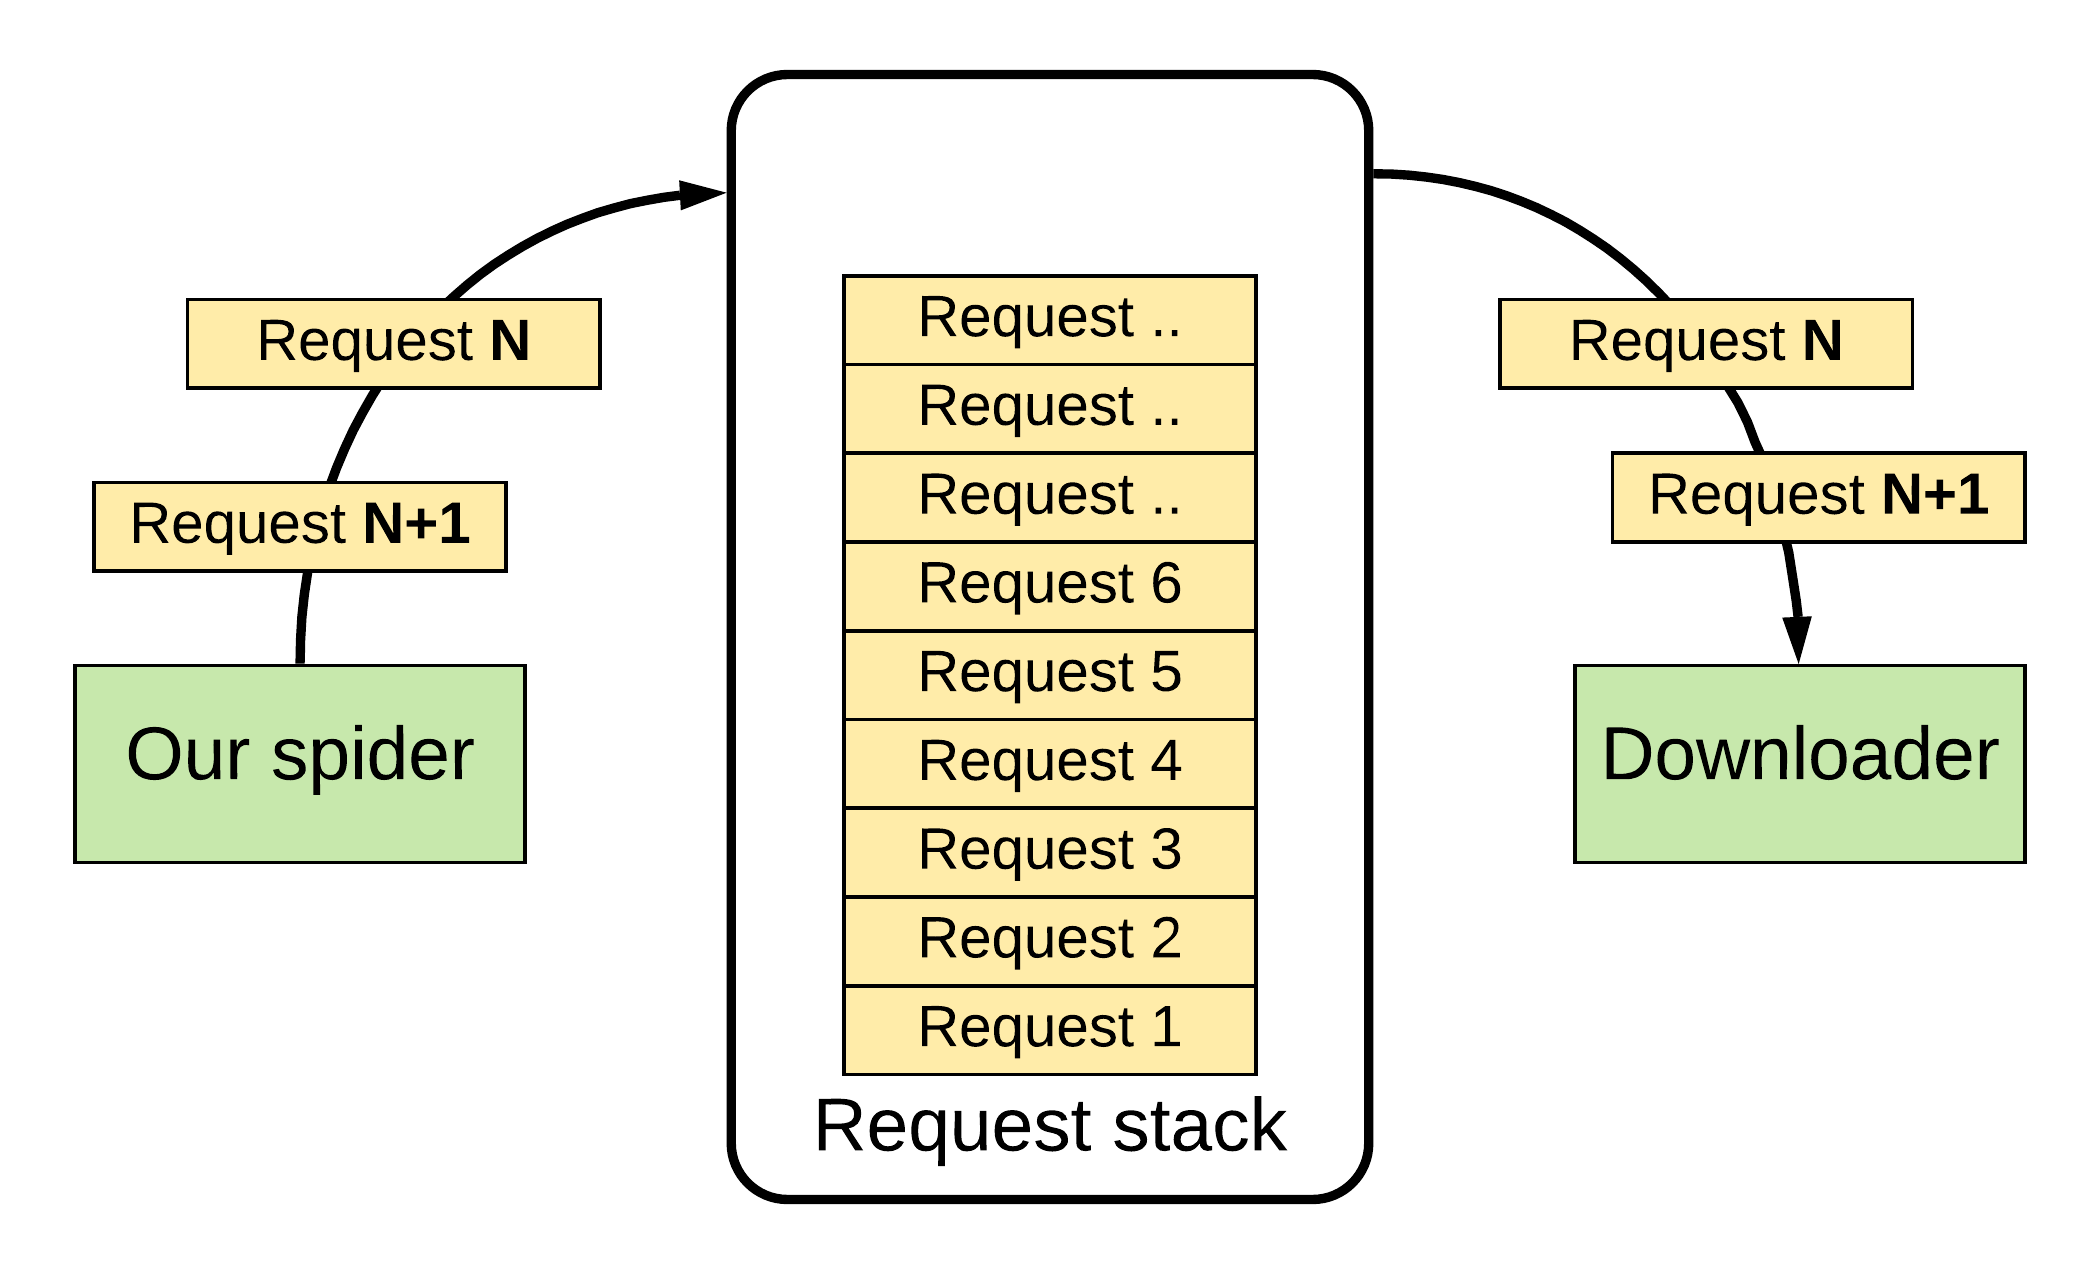
- That's because the spider populates the request stack before the downloader begins
- Then the Downloader starts at the top of the stack


### We can also make it follow links
- Let's make it follow the first link in body and print out the first heading of each page
- We want to have a counter because we don't want it going on forever
- And we might want to keep record of visited pages so we stop if we start circling back

In [16]:
class WikiHeadings_follow(scrapy.Spider):
    """A spider for extracting the first heading from Wikipedia pages."""
    name="WikiHeadings_follow"
    count = 0
    max_count = 50
    visited = []
    def start_requests(self):
        urls = [
            'https://en.wikipedia.org/wiki/Wiki'
            #Add more pages here to start from various points and see what happens
        ]
        for url in urls:
            yield scrapy.Request(url=url, callback=self.parse)
    def parse(self, response):
        self.count += 1
        self.visited.append(response.url)
        print(response.url)
        print(response.xpath("//h1[contains(@class,'firstHeading')]/text()").get())
        next_page = response.xpath("//div[contains(@id,'mw-content-text')]/div/p/a[not(i)]/@href").get()
        next_url = response.urljoin(next_page)
        if next_url not in self.visited and self.count < self.max_count:
            yield response.follow(next_page, callback=self.parse)
        elif next_url in self.visited:
            print('We have visited {} before, we reached {} unique pages.'.format(next_url,self.count))
        else:
            print('We have reached the maximum number of pages, which is {}.'.format(self.count))

run_spider(WikiHeadings_follow)

https://en.wikipedia.org/wiki/Wiki
Wiki
https://en.wikipedia.org/wiki/Knowledge_base
Knowledge base
https://en.wikipedia.org/wiki/Information_storage
Data storage
https://en.wikipedia.org/wiki/Information
Information
https://en.wikipedia.org/wiki/Uncertainty
Uncertainty
https://en.wikipedia.org/wiki/Epistemic
Epistemology
https://en.wikipedia.org/wiki/Greek_language
Greek language
https://en.wikipedia.org/wiki/Modern_Greek
Modern Greek
https://en.wikipedia.org/wiki/Dialect
Dialect
https://en.wikipedia.org/wiki/Latin
Latin
https://en.wikipedia.org/wiki/Classical_language
Classical language
https://en.wikipedia.org/wiki/Language
Language
https://en.wikipedia.org/wiki/Communication
Communication
https://en.wikipedia.org/wiki/Meaning_(semiotics)
Meaning (semiotics)
https://en.wikipedia.org/wiki/Semiotics
Semiotics
https://en.wikipedia.org/wiki/Sign_process
Semiosis
We have visited https://en.wikipedia.org/wiki/Greek_language before, we reached 16 unique pages.


# Beautiful Soup
### A python library to extract data from XML files (including html)
- Parses XML strings into a Python tree structure
- Each node in the tree is one of the following:
 - Tag
 - NavigableString
 - BeautifulSoup
 - Comment
 
### Let's take a look at it with the CS staff page
- Making the soup is as easy as just reading the file
- Printing the soup will just print out the html file contents

In [17]:
with open('data/whois.html','r') as fid:
    soup = BeautifulSoup(fid)

print(soup)

FileNotFoundError: [Errno 2] No such file or directory: 'data/whois.html'

## Let's see if we can find the names of the staff like we did before
### Navigating the tree by accessing the first child node
- The staff list is in a table under a form

In [18]:
print(soup.body.section.form.table.tr)

NameError: name 'soup' is not defined

### That only gets us the first element and that didn't even contain any names <br> and we want every staff member
- __.find_all()__ returns a list of tags which we can iterate over and it accepts:
 - strings to match with tag names, as a single string or a list of tags 
 - regular expressions
 - a filtering function
 - True: returns all tags and no strings (good for eliminating empty strings)
- __.children()__ returns a list of all immediate children but not their children

### Let's just get all the __tr__ elements from the table

In [19]:
for tag in soup.body.section.form.table.find_all('tr'):
    print("\ntr tag:")
    for child in tag.children:
        display(child)

NameError: name 'soup' is not defined

### Still gets us a lot of unwanted __empty__ string elements
- __.get_text()__ returns the flattened text of the node and all its children
 - It doesn't work with NavigableString
 - but we can apply it to the __tr__ tags
 - Then we can just use built in string methods to find what we need

In [ ]:
for tag in soup.body.section.form.table.find_all('tr'):
    tr = tag.get_text() # first get the flattened text
    tr =  tr.strip().split('\n')# split on new line 
    if len(tr)==4: # we only want rows with 4 columns
        print(','.join(tr))

### Less useful for data analysis but maybe helpful to visualise the tree
#### __prettify__

In [ ]:
print(soup.body.section.form.table.prettify())